# Exploring Airbnb Market Trends in New York City

![NYC Skyline](https://images.unsplash.com/photo-1448317846460-907988886b33?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D)

*Photo by [Todd Quackenbush](https://unsplash.com/@toddquackenbush) on [Unsplash](https://unsplash.com)*

## Project Overview

This project delves into the vibrant New York City Airbnb market, exploring various trends in room types, neighborhood distribution, pricing, and more. By merging datasets from different file formats such as `.csv`, `.tsv`, and `.xlsx`, this project aims to provide insights that could be valuable for real estate professionals, travelers, and data enthusiasts alike.

## Motivation

With New York City being one of the most popular tourist destinations globally, the demand for temporary lodging is immense. Airbnb, as a key player in this market, offers diverse listings ranging from shared rooms to entire homes. This project seeks to uncover patterns and trends within this market, focusing on the most common room types, price distributions, and neighborhood prevalence.

## Data Sources

The analysis is based on data from 2019, comprising the following files:

- **`airbnb_price.csv`**: Contains data on Airbnb listing prices and locations.

  - **`listing_id`**: Unique identifier of the listing.

  - **`price`**: Nightly listing price in USD.

  - **`nbhood_full`**: Name of the borough and neighborhood where the listing is located.

- **`airbnb_room_type.xlsx`**: Contains data on Airbnb listing descriptions and room types.

  - **`listing_id`**: Unique identifier of the listing.

  - **`description`**: Listing description.

  - **`room_type`**: Room types including shared rooms, private rooms, and entire homes/apartments.

- **`airbnb_last_review.tsv`**: Contains data on Airbnb host names and review dates.

  - **`listing_id`**: Unique identifier of the listing.

  - **`host_name`**: Name of the listing host.

  - **`last_review`**: Date when the listing was last reviewed.

## Analysis Plan

1. **Data Cleaning:**

   - Load and clean the datasets (`airbnb_last_review.tsv`, `airbnb_price.csv`, `airbnb_room_type.xlsx`).

   - Address any discrepancies in room types using string similarity techniques.

2. **Analysis Questions:**

	-	What is the most common room type in Airbnb listings for NYC?

	-	Which boroughs do Airbnb listings exist in and which one is the most prevalent?

	-	What is the average price for each room type and borough combination?

	-	What is the price distribution for each room type?

	-	Which neighborhoods have the most Airbnb listings?

### Importing necessary libraries

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from thefuzz import process

### Loading the `airbnb_last_review.tsv` Dataset

In [150]:
airbnb_last_review = pd.read_csv(r"data\airbnb_last_review.tsv", delimiter='\t', parse_dates=["last_review"])
airbnb_last_review.head()

,listing_id,host_name,last_review
0,2595,Jennifer,2019-05-21
1,3831,LisaRoxanne,2019-07-05
2,5099,Chris,2019-06-22
3,5178,Shunichi,2019-06-24
4,5238,Ben,2019-06-09


### Loading the `airbnb_price.csv` Dataset

In [151]:
airbnb_price = pd.read_csv(r"data\airbnb_price.csv")
airbnb_price.head()

,listing_id,price,nbhood_full
0,2595,225 dollars,"Manhattan, Midtown"
1,3831,89 dollars,"Brooklyn, Clinton Hill"
2,5099,200 dollars,"Manhattan, Murray Hill"
3,5178,79 dollars,"Manhattan, Hell's Kitchen"
4,5238,150 dollars,"Manhattan, Chinatown"


Let's clean the `price` column by keeping the digits only 

In [152]:
# [^0-9] matches any character that is not a digit
airbnb_price['price'] = airbnb_price['price'].str.replace("[^0-9]", "", regex=True).astype(int)
airbnb_price['price'].head()

0    225
1     89
2    200
3     79
4    150
Name: price, dtype: int32

In [153]:
print(airbnb_price.loc[airbnb_price['price'] == 0].shape[0])
airbnb_price.loc[airbnb_price['price'] == 0]

7


,listing_id,price,nbhood_full
10861,20333471,0,"Bronx, East Morrisania"
10958,20523843,0,"Brooklyn, Bushwick"
11023,20639628,0,"Brooklyn, Bedford-Stuyvesant"
11024,20639792,0,"Brooklyn, Bedford-Stuyvesant"
11025,20639914,0,"Brooklyn, Bedford-Stuyvesant"
11577,21291569,0,"Brooklyn, Bushwick"
11589,21304320,0,"Brooklyn, Bushwick"


Let's drop these rows with prices equal 0 as they affect visualizations related to prices badly and they are only 7 entries, so we will not lose much data

In [154]:
airbnb_price = airbnb_price.loc[airbnb_price['price'] != 0]

### Loading the `airbnb_room_type.xlsx` Dataset

In [155]:
# if it contains one sheet or you can select one sheet by passing its name to the `sheet_name` argument
# airbnb_room_type = pd.read_excel(r"data\airbnb_room_type.xlsx")

airbnb_excel = pd.ExcelFile(r"data\airbnb_room_type.xlsx")
airbnb_excel.sheet_names

['airbnb_room_type']

In [156]:
airbnb_room_type = airbnb_excel.parse("airbnb_room_type")
airbnb_room_type.head()

,listing_id,description,room_type
0,2595,Skylit Midtown Castle,Entire home/apt
1,3831,Cozy Entire Floor of Brownstone,Entire home/apt
2,5099,Large Cozy 1 BR Apartment In Midtown East,Entire home/apt
3,5178,Large Furnished Room Near B'way,private room
4,5238,Cute & Cozy Lower East Side 1 bdrm,Entire home/apt


In [157]:
airbnb_room_type['room_type'].unique()

array(['Entire home/apt', 'private room', 'Private room',
       'entire home/apt', 'PRIVATE ROOM', 'shared room',
       'ENTIRE HOME/APT', 'Shared room', 'SHARED ROOM'], dtype=object)

### Finding the appropriate cutoff point

It seems that there the `room_type` column has many unique values; however, there should be 3 → 'shared room', 'private room', 'entire home/apt'.

We can fix this using the `.replace()` method, but it's not practical if there are more typos and different formats. Therefore, I will fix this situation using string similarity techniques.

In [158]:
room_types = ['shared room', 'private room', 'entire home/apt']
unique_types = airbnb_room_type['room_type'].unique()

for room_type in room_types:
    print(process.extract(room_type, unique_types, limit=len(unique_types)))

[('shared room', 100), ('Shared room', 100), ('SHARED ROOM', 100), ('private room', 61), ('Private room', 61), ('PRIVATE ROOM', 61), ('Entire home/apt', 38), ('entire home/apt', 38), ('ENTIRE HOME/APT', 38)]
[('private room', 100), ('Private room', 100), ('PRIVATE ROOM', 100), ('shared room', 61), ('Shared room', 61), ('SHARED ROOM', 61), ('Entire home/apt', 42), ('entire home/apt', 42), ('ENTIRE HOME/APT', 42)]
[('Entire home/apt', 100), ('entire home/apt', 100), ('ENTIRE HOME/APT', 100), ('private room', 42), ('Private room', 42), ('PRIVATE ROOM', 42), ('shared room', 38), ('Shared room', 38), ('SHARED ROOM', 38)]


It seems that the most appropriate cutoff point is `100` for this data, but let's make it `80` as there might be typos in the future

In [159]:
for room_type in room_types:
    matches = process.extract(room_type, unique_types, limit=len(unique_types))
    
    for match in matches:
        # check whether the similarity score >= 80
        if match[1] >= 80:
            # if it is, select all room_types that are spelled in this way, and set them to the correct type
            airbnb_room_type.loc[airbnb_room_type['room_type']==match[0], 'room_type'] = room_type

# An easy way for doing the task above! But, I applied a general approach that is suitable for more complicated situations
# airbnb_room_type['room_type'] = airbnb_room_type['room_type'].str.lower()

airbnb_room_type['room_type'].unique()

array(['entire home/apt', 'private room', 'shared room'], dtype=object)

### merge the 3 DataFrames into one  

In [160]:
listings = airbnb_last_review.merge(right=airbnb_price, on='listing_id').merge(right=airbnb_room_type, on='listing_id')
listings.head()

,listing_id,host_name,last_review,price,nbhood_full,description,room_type
0,2595,Jennifer,2019-05-21,225,"Manhattan, Midtown",Skylit Midtown Castle,entire home/apt
1,3831,LisaRoxanne,2019-07-05,89,"Brooklyn, Clinton Hill",Cozy Entire Floor of Brownstone,entire home/apt
2,5099,Chris,2019-06-22,200,"Manhattan, Murray Hill",Large Cozy 1 BR Apartment In Midtown East,entire home/apt
3,5178,Shunichi,2019-06-24,79,"Manhattan, Hell's Kitchen",Large Furnished Room Near B'way,private room
4,5238,Ben,2019-06-09,150,"Manhattan, Chinatown",Cute & Cozy Lower East Side 1 bdrm,entire home/apt


In [161]:
listings.isna().sum()

listing_id      0
host_name       8
last_review     0
price           0
nbhood_full     0
description    10
room_type       0
dtype: int64

There are small number of missing values in `host_name` and `description`; however, I won't drop them as they will not affect my analysis and I want to make use of the other values in the remaining columns.

### What is the most common room type in Airbnb listings for NYC?

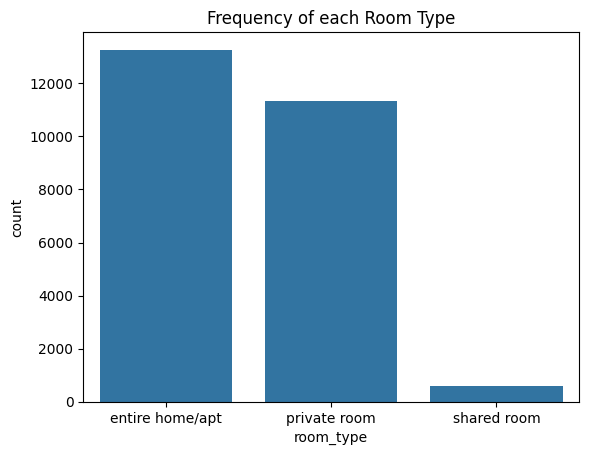

room_type
entire home/apt    13266
private room       11351
shared room          585
Name: count, dtype: int64

In [162]:
sns.countplot(data=listings, x='room_type')
plt.title("Frequency of each Room Type")
plt.show()
listings['room_type'].value_counts()

### Which boroughs do Airbnb listings exist in and which one is the most prevalent?

In [163]:
""" Another way for doing the same task below
import re
# "^.+?," → for matching one or more characters at the beginning until encountering ',' (NOT greedy)
listings["borough"] = listings['nbhood_full'].apply(lambda x: re.findall("^.+?,", x)[0].rstrip(',')) 
"""
listings["borough"] = listings['nbhood_full'].apply(lambda x: x.split(',')[0])  

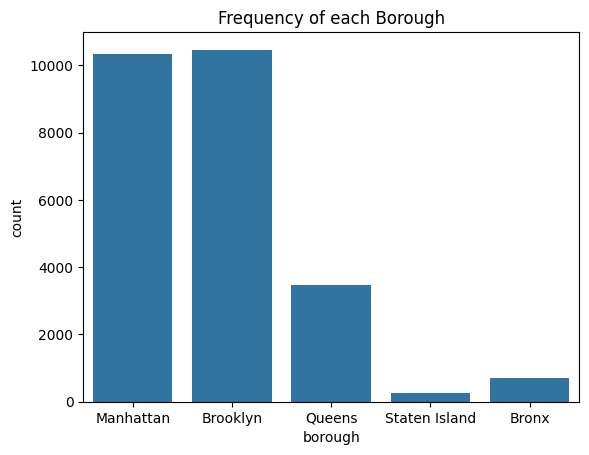

borough
Brooklyn         10460
Manhattan        10322
Queens            3456
Bronx              697
Staten Island      267
Name: count, dtype: int64

In [164]:
sns.countplot(data=listings, x='borough')
plt.title("Frequency of each Borough")
plt.show()
listings['borough'].value_counts()

### What is the average price for each room type and borough combination?

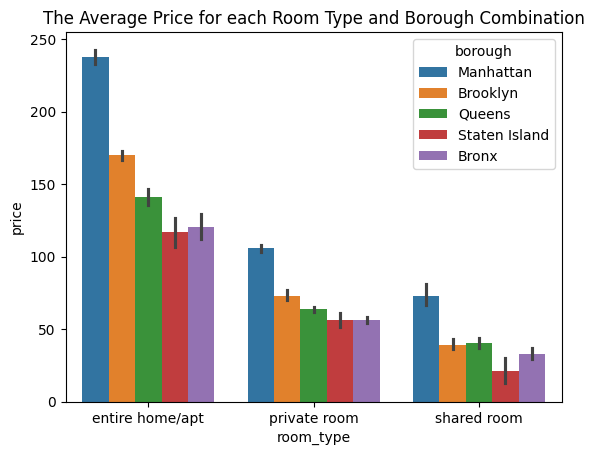

room_type
entire home/apt    197.166667
private room        81.674126
shared room         53.647863
Name: price, dtype: float64 

borough
Manhattan        184.000678
Brooklyn         121.974665
Queens            92.813947
Staten Island     86.044944
Bronx             79.241033
Name: price, dtype: float64


In [165]:
sns.barplot(data=listings, x='room_type', y='price', hue='borough')
plt.title("The Average Price for each Room Type and Borough Combination")
plt.show()
print(listings.groupby('room_type')['price'].mean().sort_values(ascending=False), '\n')
print(listings.groupby('borough')['price'].mean().sort_values(ascending=False))

### What is the price distribution for each room type?

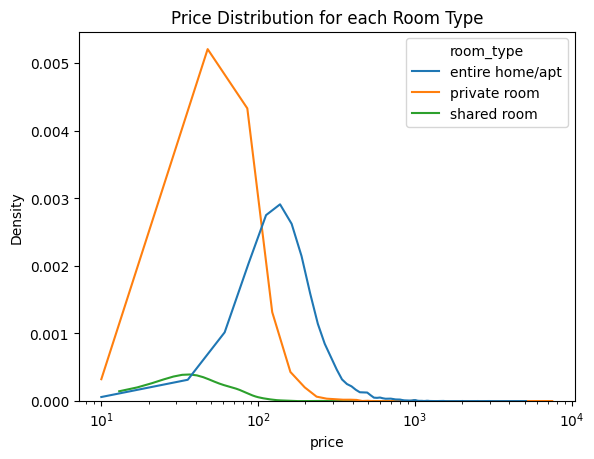

In [166]:
sns.kdeplot(data=listings, x='price', hue='room_type', cut=0)
plt.xscale('log')
plt.title("Price Distribution for each Room Type")
plt.show()

### Which neighborhoods have the most Airbnb listings?

In [167]:
listings["neighborhood"] = listings['nbhood_full'].apply(lambda x: x.split(',')[1])  
listings['neighborhood'].value_counts()

neighborhood
Bedford-Stuyvesant    2206
Williamsburg          1853
Harlem                1435
Bushwick              1199
Hell's Kitchen        1119
                      ... 
Lighthouse Hill          1
Co-op City               1
Little Neck              1
Howland Hook             1
Prince's Bay             1
Name: count, Length: 216, dtype: int64

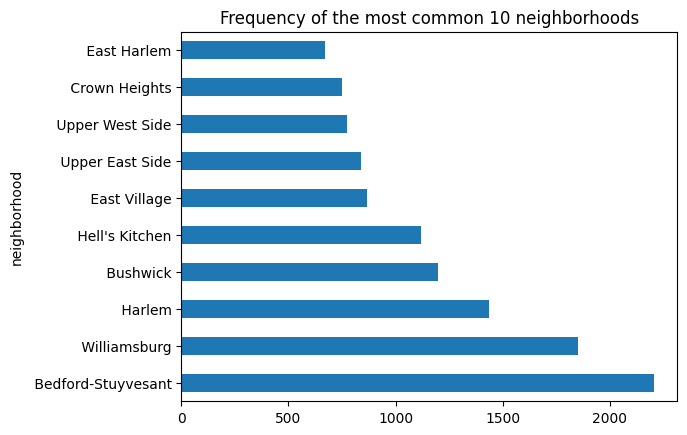

neighborhood
Bedford-Stuyvesant    2206
Williamsburg          1853
Harlem                1435
Bushwick              1199
Hell's Kitchen        1119
East Village           866
Upper East Side        839
Upper West Side        775
Crown Heights          752
East Harlem            672
Name: count, dtype: int64

In [168]:
listings['neighborhood'].value_counts().iloc[:10].plot(kind='barh')
plt.title("Frequency of the most common 10 neighborhoods")
plt.show()
listings['neighborhood'].value_counts().iloc[:10]

## Analysis Results 

- **Room Type Distribution**: The most common room type is **entire home/apt** with around 13,000 listings, followed by **private rooms** ($\approx$ 11,000 listings), and **shared rooms** ($\approx$ 500 listings).

- **Borough Distribution**: Airbnb listings are most prevalent in **Brooklyn** and **Manhattan** ($\approx$ 10,500 listings each), followed by **Queens** ($\approx$ 3,500 listings), **Bronx** ($\approx$ 700 listings), and **Staten Island** ($\approx$ 250 listings).

- **Average Price by Room Type**:

  - **Entire home/apt**: $\approx$ $195/night

  - **Private room**: $\approx$ $80/night

  - **Shared room**: $\approx$ $50/night

  - <span style="color: orange;"><strong>Note:</strong></span> However the average price of shared rooms in Manhattan is higher than the average prices of those private rooms in the remaining boroughs.

- **Average Price by Borough**:

  - **Manhattan**: $185/night

  - **Brooklyn**: $120/night

  - **Queens**: $90/night

- **Top Neighborhoods**: The most common neighborhoods include Bedford-Stuyvesant, Williamsburg, Harlem, and Bushwick, among others.